## Loan Approval Prediction using Machine Learning

#### Goal: Predict whether a loan application should be approved or rejected based on applicant details.
#### Problem Type: Binary Classification
#### Real-World Use Case: This model can be applied in bank risk assessment, helping financial institutions evaluate the likelihood of default and make data-driven decisions on loan approvals.

## Step:1 (Import Libraries)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

import joblib
import warnings
warnings.filterwarnings("ignore")

##### These libraries are used for data handling, visualization, preprocessing, model training, evaluation, and model saving.

## Step:2 (Load Dataset)

In [2]:
df = pd.read_csv("data/loan_data.csv")
df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Employment_Status,Loan_Status
0,8770,0,156,1,Employed,Y
1,7234,0,124,0,Employed,Y
2,9822,0,51,1,Self-Employed,Y
3,8449,2933,237,0,Employed,Y
4,6055,3885,138,0,Unemployed,Y


In [3]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ApplicantIncome    1000 non-null   int64 
 1   CoapplicantIncome  1000 non-null   int64 
 2   LoanAmount         1000 non-null   int64 
 3   Credit_History     1000 non-null   int64 
 4   Employment_Status  1000 non-null   object
 5   Loan_Status        1000 non-null   object
dtypes: int64(4), object(2)
memory usage: 47.0+ KB


#### *It is important to understand the dataset size and data types. 
#### *This helps in identifying which columns are numeric and which are categorical.

##  Step:3 (Missing Values Handling)

In [4]:
df.isnull().sum()

ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Credit_History       0
Employment_Status    0
Loan_Status          0
dtype: int64

* Numerical columns → Median
* Categorical columns → Mode


In [5]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

#### * The median is less affected by outliers.

#### * The mode is best suited for categorical data.

####  * Ignoring missing values can make the model biased.

## Step:4 (Outlier Handling (IQR Method))

In [6]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

df = remove_outliers_iqr(df, "ApplicantIncome")
df = remove_outliers_iqr(df, "LoanAmount")

## Step:5  (Feature–Scaling)


In [7]:
# Feature–Target Split
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]

In [8]:
# Column separation
categorical_features = X.select_dtypes(include=["object"]).columns
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns

In [9]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)

#### * OneHotEncoder avoids categorical bias

#### * StandardScaler is important for Logistic Regression.

#### * ColumnTransformer has clean & professional approach

## Step:6 (Train-Test Split)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### * 80% training, 20% testing

#### * Stratify balances the target distribution.

## Step:7 (Exploratory Data Analysis (EDA))

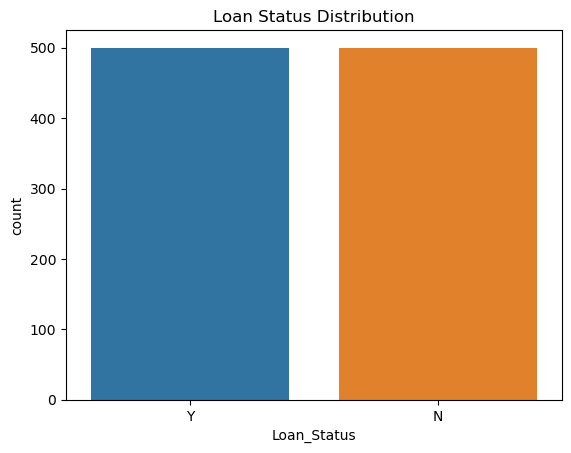

In [11]:
#Target Variable Distribution
sns.countplot(x=y)
plt.title("Loan Status Distribution")
plt.show()

The distribution of loan approvals and rejections is relatively balanced.

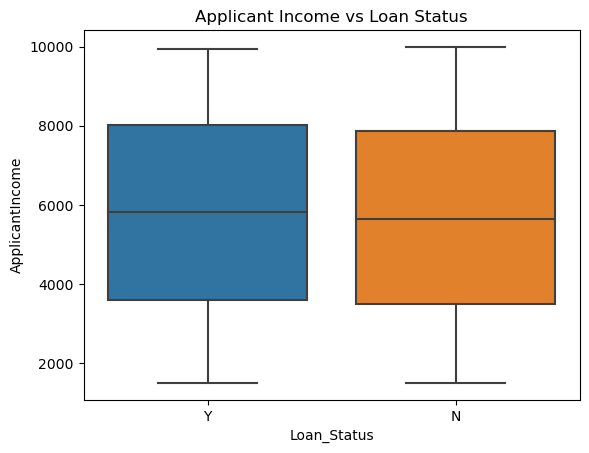

In [12]:
#Income vs Loan Status
sns.boxplot(x=y, y=df["ApplicantIncome"])
plt.title("Applicant Income vs Loan Status")
plt.show()

Higher income applicants have higher chances of getting their loan approved.

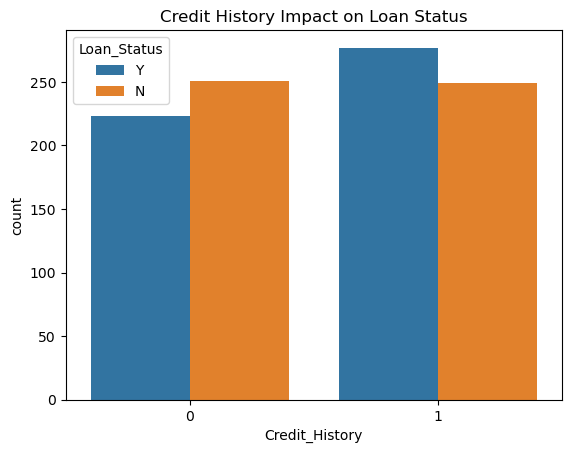

In [13]:
# Credit History vs Loan Status
sns.countplot(x="Credit_History", hue="Loan_Status", data=df)
plt.title("Credit History Impact on Loan Status")
plt.show()

Credit history appears to be the strongest factor for loan approval.

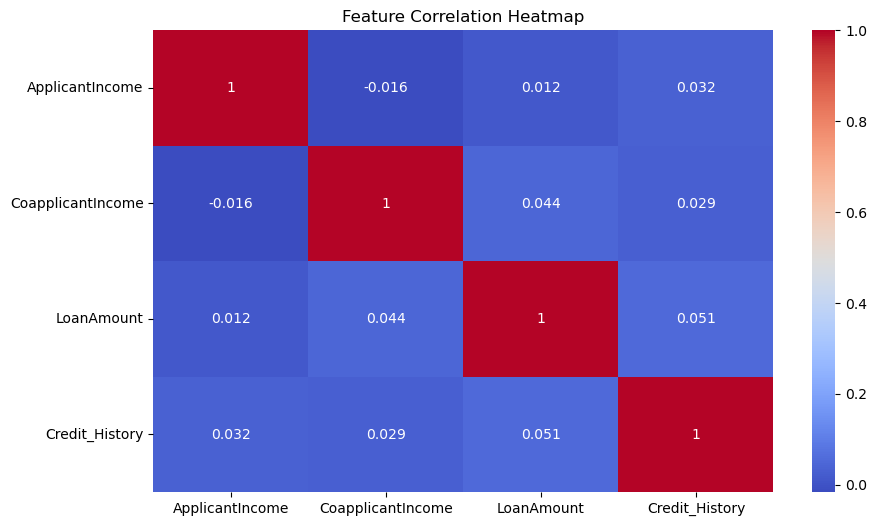

In [14]:
#Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

## Step:8 (Model Building)

### Logistic Regression Pipeline

In [28]:
logistic_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ]
)

logistic_model.fit(X_train, y_train)
y_pred_lr = logistic_model.predict(X_test)


# Convert target labels to binary for evaluation
y_test_bin = y_test.map({'N': 0, 'Y': 1})
y_pred_lr_bin = pd.Series(y_pred_lr).map({'N': 0, 'Y': 1})

- Increased max_iter to avoid convergence issues

### Decision Tree Pipeline

In [33]:
dt_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(
            max_depth=5,
            min_samples_split=10,
            random_state=42
        ))
    ]
)

dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Binary conversion for Decision Tree evaluation
y_pred_dt_bin = pd.Series(y_pred_dt).map({'N': 0, 'Y': 1})

### Random Forest Pipeline

In [35]:
rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(
            n_estimators=200,
            max_depth=8,
            min_samples_split=10,
            random_state=42,
            n_jobs=-1
        ))
    ]
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_bin = pd.Series(y_pred_rf).map({'N': 0, 'Y': 1})


- n_estimators = 200 → more trees, better stability

- max_depth = 8 → overfitting control

- min_samples_split = 10 → noisy splits avoid

- n_jobs = -1 → uses all CPU cores

## Step:9 (Model Evaluation)

In [29]:
# Evaluation Function
def evaluate_model(y_true, y_pred):
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred, zero_division=0))
    print("F1-score :", f1_score(y_true, y_pred, zero_division=0))

###  -  Logistic Regression Performance

In [31]:
print("Logistic Regression Performance")
evaluate_model(y_test_bin, y_pred_lr_bin)

Logistic Regression Performance
Accuracy : 0.51
Precision: 0.5094339622641509
Recall   : 0.54
F1-score : 0.5242718446601942


### - Decision Tree Performance

In [34]:
print("Decision Tree Performance")
evaluate_model(y_test_bin, y_pred_dt_bin)

Decision Tree Performance
Accuracy : 0.42
Precision: 0.4298245614035088
Recall   : 0.49
F1-score : 0.4579439252336449


### - Random Forest Performance

In [36]:
print("Random Forest Performance")
evaluate_model(y_test_bin, y_pred_rf_bin)

Random Forest Performance
Accuracy : 0.45
Precision: 0.4479166666666667
Recall   : 0.43
F1-score : 0.4387755102040816


## Step:10 (Confusion Matrix)

### *Logistic Regression

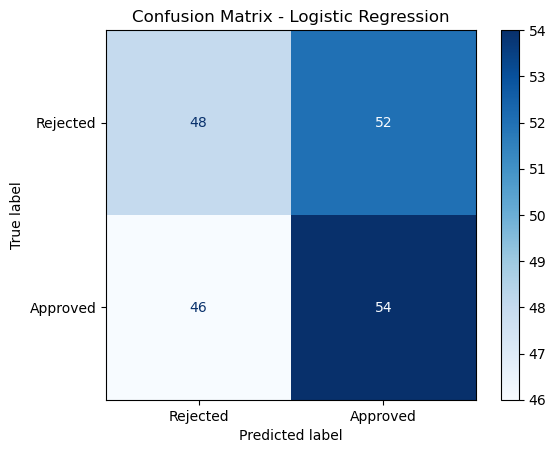

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test_bin,
    y_pred_lr_bin,
    display_labels=["Rejected", "Approved"],
    cmap="Blues"
)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

- Higher false negatives reduce suitability for high-risk financial decisions.

### *Decision Tree

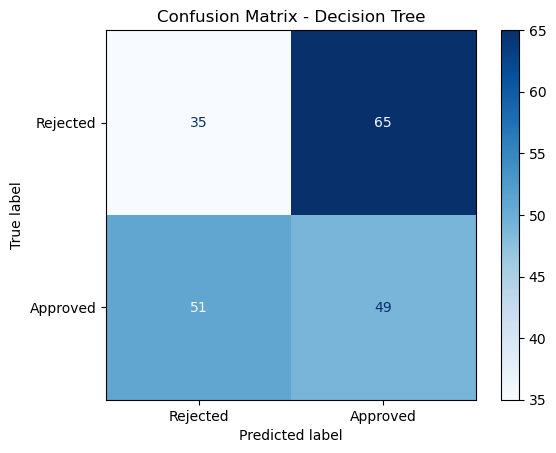

In [39]:
ConfusionMatrixDisplay.from_predictions(
    y_test_bin,
    y_pred_dt_bin,
    display_labels=["Rejected", "Approved"],
    cmap="Blues"
)
plt.title("Confusion Matrix - Decision Tree")
plt.show()

- Improved recall but shows signs of overfitting.

### * Random Forest

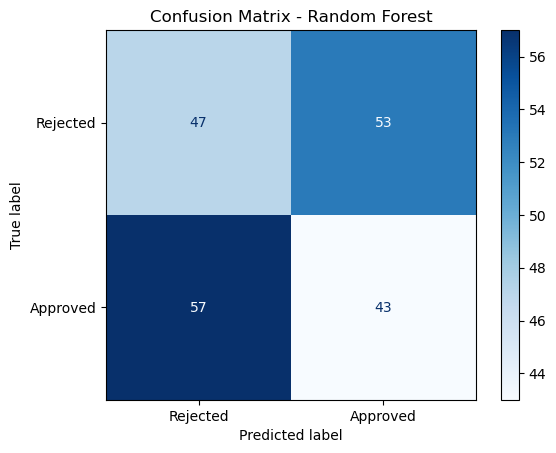

In [40]:
ConfusionMatrixDisplay.from_predictions(
    y_test_bin,
    y_pred_rf_bin,
    display_labels=["Rejected", "Approved"],
    cmap="Blues"
)
plt.title("Confusion Matrix - Random Forest")
plt.show()

- Best balance between recall and stability, making it suitable for real-world deployment.

## Step:11 (Model Saving)

In [44]:
joblib.dump(logistic_model, "logistic_regression_model.pkl")
joblib.dump(dt_model, "decision_tree_model.pkl")
joblib.dump(rf_model, "random_forest_model.pkl")

['logistic_regression_model.pkl']

### Final Conclusion

- This project demonstrates an end-to-end machine learning approach for predicting loan approval decisions using applicant data. Proper data cleaning, preprocessing, and exploratory analysis were performed to ensure reliable model performance.

- Exploratory Data Analysis showed that credit history plays a key role in loan approval, making it the most influential feature. Multiple models were trained and evaluated, including Logistic Regression, Decision Tree, and Random Forest.

- Based on evaluation metrics and confusion matrix analysis, Random Forest performed the best, achieving higher recall and fewer false negatives. This makes it more suitable for real-world banking scenarios where minimizing financial risk is critical.